# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test2.pkl")

In [ ]:
CHANNELS = 3
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))


In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))

The shape of LC25000_train_data:  (3200, 256, 256, 3)
The shape of LC25000_train_labels:  (3200,)


In [ ]:
import gc
gc.collect()

272

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train1), "rb") as f:
    TCGA_train1 = pickle.load(f)
with open(os.path.abspath(Target_dir_test1), "rb") as f:
    TCGA_test1 = pickle.load(f)
with open(os.path.abspath(Target_dir_train2), "rb") as f:
    TCGA_train2 = pickle.load(f)
with open(os.path.abspath(Target_dir_test2), "rb") as f:
    TCGA_test2 = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train1['train'] + TCGA_train2['train']
TCGA_train_labels = np.concatenate((TCGA_train1['train_label'],TCGA_train2['train_label']))
TCGA_test_data = TCGA_test1['test'] + TCGA_test2['test']
TCGA_test_labels = np.concatenate((TCGA_test1['test_label'],TCGA_test2['test_label']))

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)

In [ ]:
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (3200, 256, 256, 3)
The shape of TCGA_train_labels:  (3200,)
The shape of TCGA_test_data:  (3200, 256, 256, 3)
The shape of TCGA_test_labels:  (3200,)


In [ ]:
import gc
gc.collect()

253

## Datasets Visualization

<function matplotlib.pyplot.show>

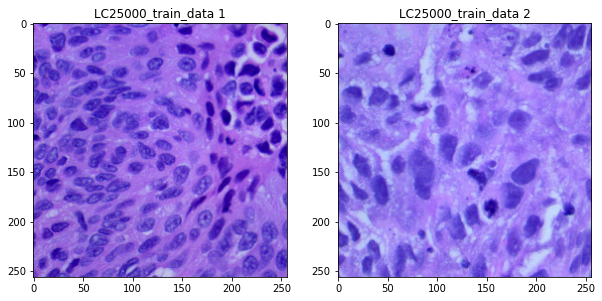

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

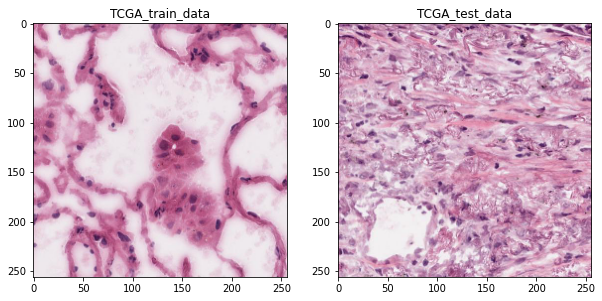

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - VGG

In [ ]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block_256.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block_256.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 512)]     0         
                                                                 
 block5_conv1 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 8, 8, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))

print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data (source) shape: (3200, 256, 256, 3)
TCGA_train_data (target) shape: (3200, 256, 256, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 7s 17ms/step - loss: 1.6747e-06 - acc: 1.0000 - val_loss: 14.4257 - val_acc: 0.4256
Epoch 2/100
400/400 [==============================] - 6s 16ms/step - loss: 1.8811e-07 - acc: 1.0000 - val_loss: 14.4604 - val_acc: 0.4259
Epoch 3/100
400/400 [==============================] - 6s 16ms/step - loss: 3.0981e-07 - acc: 1.0000 - val_loss: 14.4428 - val_acc: 0.4266
Epoch 4/100
400/400 [==============================] - 6s 16ms/step - loss: 3.1676e-07 - acc: 1.0000 - val_loss: 14.4103 - val_acc: 0.4266
Epoch 5/100
400/400 [==============================] - 6s 16ms/step - loss: 2.1365e-07 - acc: 1.0000 - val_loss: 14.4521 - val_acc: 0.4250
Epoch 6/100
400/400 [==============================] - 6s 16ms/step - loss: 3.8498e-07 - acc: 1.0000 - val_loss: 14.4294 - val_acc: 0.4253
Epoch 7/100
400/400 [==============================] - 6s 16ms/step - loss: 1.1102e-06 - acc: 1.0000 - val_loss: 13.8884 - val_acc: 0.4238
Epoch 8/100
400/400 [======

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 8s 13ms/step - loss: 0.6785 - acc: 0.8281 - val_loss: 2.0170 - val_acc: 0.4481
Epoch 2/5
400/400 [==============================] - 4s 10ms/step - loss: 0.2332 - acc: 0.9237 - val_loss: 2.3358 - val_acc: 0.4556
Epoch 3/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1788 - acc: 0.9413 - val_loss: 2.3977 - val_acc: 0.4425
Epoch 4/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1674 - acc: 0.9453 - val_loss: 2.6638 - val_acc: 0.4456
Epoch 5/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1324 - acc: 0.9559 - val_loss: 2.6019 - val_acc: 0.4597
Epoch 1/100
400/400 [==============================] - 9s 18ms/step - loss: 0.1350 - acc: 0.9600 - val_loss: 2.8903 - val_acc: 0.4462
Epoch 2/100
400/400 [==============================] - 6s 15ms/step - loss: 0.0914 - acc: 0.9737 - val_loss: 3.3358 - val_acc: 0.4434
Epoch 3/100
400/400 [==============================] - 6s 15ms/step - lo

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 6s 12ms/step - loss: 0.6455 - acc: 0.8219 - val_loss: 1.9123 - val_acc: 0.4216
Epoch 2/5
400/400 [==============================] - 4s 10ms/step - loss: 0.2396 - acc: 0.9194 - val_loss: 2.5842 - val_acc: 0.3978
Epoch 3/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1934 - acc: 0.9400 - val_loss: 2.6811 - val_acc: 0.4000
Epoch 4/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1735 - acc: 0.9428 - val_loss: 2.7384 - val_acc: 0.4131
Epoch 5/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1523 - acc: 0.9481 - val_loss: 3.0782 - val_acc: 0.4081
Epoch 1/100
400/400 [==============================] - 8s 17ms/step - loss: 0.1412 - acc: 0.9556 - val_loss: 3.0451 - val_acc: 0.4116
Epoch 2/100
400/400 [==============================] - 6s 15ms/step - loss: 0.1007 - acc: 0.9728 - val_loss: 3.7366 - val_acc: 0.4050
Epoch 3/100
400/400 [==============================] - 6s 15ms/step - lo

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 6s 13ms/step - loss: 0.6885 - acc: 0.8259 - val_loss: 2.0233 - val_acc: 0.4516
Epoch 2/5
400/400 [==============================] - 4s 10ms/step - loss: 0.2222 - acc: 0.9225 - val_loss: 2.0436 - val_acc: 0.4466
Epoch 3/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1671 - acc: 0.9447 - val_loss: 2.3837 - val_acc: 0.4394
Epoch 4/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1682 - acc: 0.9472 - val_loss: 2.4749 - val_acc: 0.4647
Epoch 5/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1287 - acc: 0.9600 - val_loss: 2.5473 - val_acc: 0.4603
Epoch 1/100
400/400 [==============================] - 8s 18ms/step - loss: 0.1295 - acc: 0.9606 - val_loss: 2.8595 - val_acc: 0.4450
Epoch 2/100
400/400 [==============================] - 6s 16ms/step - loss: 0.1072 - acc: 0.9706 - val_loss: 2.9090 - val_acc: 0.4616
Epoch 3/100
400/400 [==============================] - 6s 16ms/step - lo

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
400/400 [==============================] - 6s 13ms/step - loss: 0.6105 - acc: 0.8444 - val_loss: 1.8492 - val_acc: 0.4412
Epoch 2/5
400/400 [==============================] - 4s 10ms/step - loss: 0.2506 - acc: 0.9209 - val_loss: 2.1984 - val_acc: 0.4338
Epoch 3/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1762 - acc: 0.9431 - val_loss: 2.4212 - val_acc: 0.4425
Epoch 4/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1616 - acc: 0.9444 - val_loss: 2.8021 - val_acc: 0.4328
Epoch 5/5
400/400 [==============================] - 4s 10ms/step - loss: 0.1466 - acc: 0.9528 - val_loss: 2.7225 - val_acc: 0.4366
Epoch 1/100
400/400 [==============================] - 8s 17ms/step - loss: 0.1446 - acc: 0.9572 - val_loss: 3.0489 - val_acc: 0.4409
Epoch 2/100
400/400 [==============================] - 6s 15ms/step - loss: 0.1052 - acc: 0.9700 - val_loss: 3.9217 - val_acc: 0.4187
Epoch 3/100
400/400 [==============================] - 6s 15ms/step - lo

### Result

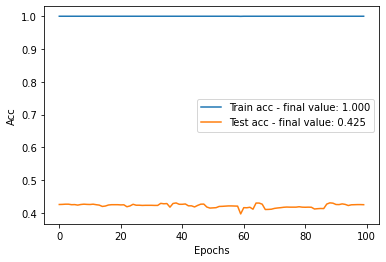

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


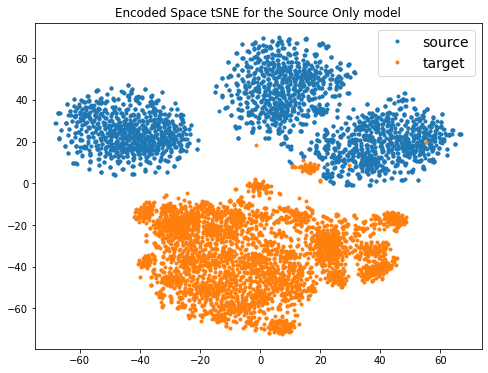

In [ ]:
LC25000_train_data_enc = finetunig.transform(LC25000_train_data_ex)
TCGA_train_data_enc = finetunig.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,1.000000e+02,100.000000,100.000000,100.000000
mean,7.293300e-06,0.999997,14.684016,0.421712
std,4.888670e-05,0.000031,0.314429,0.005655
min,1.235120e-07,0.999687,13.888415,0.396875
25%,1.717090e-07,1.000000,14.444527,0.417500
50%,2.954985e-07,1.000000,14.660838,0.423125
75%,7.617753e-07,1.000000,14.871006,0.425703
max,4.672347e-04,1.000000,15.334541,0.430625


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_source_VGG_256_RMS_0.5e-5.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


### Run 2

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 17s 29ms/step - loss: 0.5523 - acc: 0.8403 - disc_loss: 0.8666 - val_loss: 2.9559 - val_acc: 0.4659
Epoch 2/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1628 - acc: 0.9431 - disc_loss: 0.7815 - val_loss: 4.3968 - val_acc: 0.4644
Epoch 3/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1814 - acc: 0.9484 - disc_loss: 2.4944 - val_loss: 6.1199 - val_acc: 0.4859
Epoch 4/100
400/400 [==============================] - 11s 27ms/step - loss: 0.2023 - acc: 0.9491 - disc_loss: 4.5904 - val_loss: 7.0031 - val_acc: 0.4647
Epoch 5/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1924 - acc: 0.9553 - disc_loss: 3.7635 - val_loss: 5.8698 - val_acc: 0.4563
Epoch 6/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1706 - acc: 0.9631 - disc_loss: 2.7784 - val_loss: 8.5239 - val_acc: 0.4850
Epoch 7/100
400/400 [==============================] - 11s 27ms/step -

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 15s 30ms/step - loss: 0.6166 - acc: 0.8441 - disc_loss: 0.7619 - val_loss: 2.8019 - val_acc: 0.4503
Epoch 2/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1778 - acc: 0.9459 - disc_loss: 0.7617 - val_loss: 4.0860 - val_acc: 0.4519
Epoch 3/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1897 - acc: 0.9488 - disc_loss: 3.6843 - val_loss: 4.4364 - val_acc: 0.4519
Epoch 4/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1792 - acc: 0.9513 - disc_loss: 6.9865 - val_loss: 9.9201 - val_acc: 0.4928
Epoch 5/100
400/400 [==============================] - 11s 27ms/step - loss: 0.2103 - acc: 0.9553 - disc_loss: 5.8101 - val_loss: 4.3696 - val_acc: 0.4681
Epoch 6/100
400/400 [==============================] - 11s 27ms/step - loss: 0.2099 - acc: 0.9600 - disc_loss: 5.0934 - val_loss: 4.9458 - val_acc: 0.4472
Epoch 7/100
400/400 [==============================] - 11s 27ms/step -

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 15s 29ms/step - loss: 0.5526 - acc: 0.8409 - disc_loss: 0.8651 - val_loss: 2.9528 - val_acc: 0.4666
Epoch 2/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1628 - acc: 0.9413 - disc_loss: 0.7782 - val_loss: 4.5032 - val_acc: 0.4588
Epoch 3/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1809 - acc: 0.9488 - disc_loss: 2.5259 - val_loss: 6.9030 - val_acc: 0.4881
Epoch 4/100
400/400 [==============================] - 11s 27ms/step - loss: 0.2079 - acc: 0.9503 - disc_loss: 4.6618 - val_loss: 6.9768 - val_acc: 0.4694
Epoch 5/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1909 - acc: 0.9575 - disc_loss: 3.7247 - val_loss: 6.0504 - val_acc: 0.4556
Epoch 6/100
400/400 [==============================] - 11s 27ms/step - loss: 0.1619 - acc: 0.9650 - disc_loss: 2.8731 - val_loss: 9.0636 - val_acc: 0.4831
Epoch 7/100
400/400 [==============================] - 11s 27ms/step -

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 16s 31ms/step - loss: 0.7117 - acc: 0.8319 - disc_loss: 0.7229 - val_loss: 2.8048 - val_acc: 0.4353
Epoch 2/100
400/400 [==============================] - 11s 29ms/step - loss: 0.1667 - acc: 0.9428 - disc_loss: 0.8103 - val_loss: 4.4219 - val_acc: 0.4578
Epoch 3/100
400/400 [==============================] - 11s 29ms/step - loss: 0.1644 - acc: 0.9534 - disc_loss: 4.3482 - val_loss: 9.4775 - val_acc: 0.4822
Epoch 4/100
400/400 [==============================] - 11s 29ms/step - loss: 0.2075 - acc: 0.9538 - disc_loss: 7.7641 - val_loss: 7.9194 - val_acc: 0.4794
Epoch 5/100
400/400 [==============================] - 11s 29ms/step - loss: 0.2323 - acc: 0.9547 - disc_loss: 6.2849 - val_loss: 9.0837 - val_acc: 0.4816
Epoch 6/100
400/400 [==============================] - 11s 29ms/step - loss: 0.1715 - acc: 0.9603 - disc_loss: 4.2849 - val_loss: 9.9558 - val_acc: 0.4797
Epoch 7/100
400/400 [==============================] - 11s 28ms/step -

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 15s 30ms/step - loss: 0.5521 - acc: 0.8406 - disc_loss: 0.8675 - val_loss: 2.9421 - val_acc: 0.4659
Epoch 2/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1639 - acc: 0.9406 - disc_loss: 0.8041 - val_loss: 4.4657 - val_acc: 0.4625
Epoch 3/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1784 - acc: 0.9466 - disc_loss: 2.5447 - val_loss: 6.8221 - val_acc: 0.4884
Epoch 4/100
400/400 [==============================] - 11s 28ms/step - loss: 0.2008 - acc: 0.9503 - disc_loss: 4.6022 - val_loss: 6.5985 - val_acc: 0.4669
Epoch 5/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1841 - acc: 0.9547 - disc_loss: 3.6975 - val_loss: 5.5538 - val_acc: 0.4550
Epoch 6/100
400/400 [==============================] - 11s 28ms/step - loss: 0.1668 - acc: 0.9634 - disc_loss: 2.8626 - val_loss: 6.1879 - val_acc: 0.4609
Epoch 7/100
400/400 [==============================] - 11s 27ms/step -

### Result

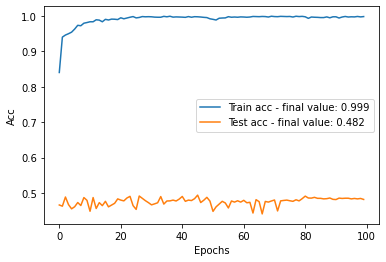

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


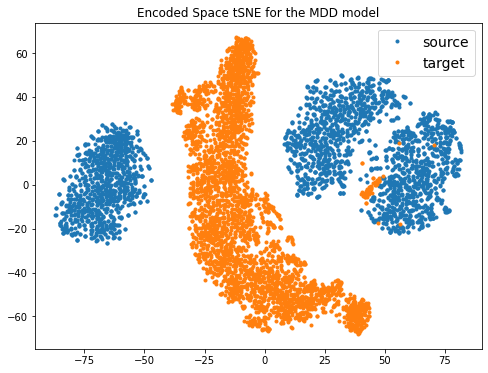

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.035218,0.991681,0.477315,20.576219,0.475706
std,0.066492,0.018860,1.197884,13.070938,0.011045
min,0.000865,0.840625,0.000087,2.942063,0.440625
25%,0.007555,0.993984,0.000131,8.820283,0.472031
50%,0.015178,0.997187,0.000150,16.598849,0.477656
75%,0.030381,0.998438,0.001289,28.180688,0.483750
max,0.552081,0.999687,6.402255,53.098198,0.493750


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_VGG_256_RMS_0.5e-5_g1e-5.csv")